# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = './Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

# imports
import pandas as pd
import os
import numpy as np
import warnings

# ignore annoying warnings
warnings.filterwarnings('ignore')

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

## Assumptions

### field names
- The fields "National" in SL and Liberia mean the same as the "Totals" field in Guinea, i.e. the Total number of cases in the country.

### missing data
- When there's a NaN (the value was not filled), we assume that the data was lost, or not written down.
- When a report (csv file) for a given day is missing, we assume that nothing happened during this day.
- We are only interested in the Totals/National columns. If a row contains a NaN in this column, we chose to discard the row. This should not be problematic (if the number of NaNs in *Totals* is reasonably low), since we consider the daily **average** per month.

### fields meaning and aggregation
- Since we don't have additionnal information on the data, especially about the meanings of some fields, we decide to compute the new cases separaterly for the confirmed, probable and suspect cases. Same goes for the deaths.
    - We also add a column that sums all the new cases/deaths


### Used/Discarded fields
- We only consider the totals/national fields, not the values per district/region. Sometimes, the sum of the values per region is a bit higher than the total. We assume that's because some smaller regions are not shown in the data.
    - For this reason, if the *Totals* value is NaN, we cannot just sum up the values of the different regions.
- After observing the data, we can safely assume that the deaths, unlike the new cases, are reported cumulatively. I.e., the number of deaths reported on day *d* is the number of deaths that happened this day, plus all the deaths that happened in the previous days. We did not use the *new deaths* values, because for some countries there is no distinction between the different cases (confirmed, probable and suspected).

## Overall Process
- Importing the data
- Merge and clean the full dataset
- Unstack Description column
- Daily averages computation
- Results
- Discussion

### 1. Importing the data

In [103]:
# import data from CSVs
guinea = []
liberia = []
sl = []
dfs = [guinea, liberia, sl]
i = 0
folders = ["guinea_data", "liberia_data", "sl_data"]
for folder in folders:
    path = DATA_FOLDER + "/ebola/"
    for file in os.listdir(path + folder):
        dfs[i].append(pd.read_csv(path + folder + '/' + file))
    i += 1

In [104]:
# import Guinea data into DataFrame
guinea = pd.DataFrame()
i = 0
for df in dfs[0]:
    df['Country'] = 'Guinea' # set the new country column
    dfs[0][i] = df
    i += 1
guinea = pd.concat(dfs[0])
guinea.head(2)

,Beyla,Boffa,Conakry,Country,Coyah,Dabola,Dalaba,Date,Description,Dinguiraye,...,Kouroussa,Lola,Macenta,Mzerekore,Nzerekore,Pita,Siguiri,Telimele,Totals,Yomou
0,NaN,0,5,Guinea,NaN,0,NaN,2014-08-04,New cases of suspects,0,...,0,NaN,0,NaN,0,0,0,0,5,NaN
1,NaN,0,0,Guinea,NaN,0,NaN,2014-08-04,New cases of probables,0,...,0,NaN,0,NaN,0,0,0,0,0,NaN


In [105]:
# import liberia data into DataFrame
liberia = pd.DataFrame()
i = 0
for df in dfs[1]:
    df['Country'] = 'Liberia'
    df = df.rename(columns = {'National':'Totals', 'Variable':'Description'})
    dfs[1][i] = df
    i += 1
liberia = pd.concat(dfs[1])
liberia.head(2)

,Bomi County,Bong County,Country,Date,Description,Gbarpolu County,Grand Bassa,Grand Cape Mount,Grand Gedeh,Grand Kru,Lofa County,Margibi County,Maryland County,Montserrado County,Nimba County,River Gee County,RiverCess County,Sinoe County,Totals,Unnamed: 18
0,NaN,NaN,Liberia,6/16/2014,Specimens collected,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN
1,NaN,NaN,Liberia,6/16/2014,Specimens pending for testing,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN


In [106]:
# import Sierra Leone data into DataFrame
sl = pd.DataFrame()
i = 0
for df in dfs[2]:
    df['Country'] = 'Sierra Leone'
    df = df.rename(columns = {'National':'Totals', 'date' : 'Date', 'variable':'Description'})
    dfs[2][i] = df
    i += 1
sl = pd.concat(dfs[2])
sl.head(2)

,34 Military Hospital,Bo,Bo EMC,Bombali,Bonthe,Country,Date,Description,Hastings-F/Town,Kailahun,...,Police traning School,Port Loko,Pujehun,Tonkolili,Totals,Unnamed: 18,Western area,Western area combined,Western area rural,Western area urban
0,NaN,654142,NaN,494139,168729,Sierra Leone,2014-08-12,population,NaN,465048,...,NaN,557978,335574,434937,6348350,NaN,NaN,NaN,263619,1040888
1,NaN,0,NaN,0,0,Sierra Leone,2014-08-12,new_noncase,NaN,0,...,NaN,1,0,0,4,NaN,NaN,NaN,0,0


### 2. Merge and clean the full dataset (all countries)

In [107]:
# merge dataframes
full_data = pd.concat([guinea, liberia, sl])

# remove each row whose 'Totals' value is NaN
n_col_before = full_data.shape[0]
full_data = full_data[full_data.Totals.notnull()]
n_col_after = full_data.shape[0]
print("Removed " + str(n_col_before-n_col_after) + " rows out of " + str(n_col_before))

# Specify that the Date column contains datetime objects
full_data.Date = pd.to_datetime(full_data.Date)

# To facilitate readability, we discard all the columns we don't need
full_data_crop = full_data[['Country', 'Description', 'Totals', 'Date']]

Removed 1685 rows out of 7128


This is what the dataframe that we'll use to compute the different values looks like so far: 

In [108]:
 full_data_crop.head(2)

,Country,Description,Totals,Date
0,Guinea,New cases of suspects,5,2014-08-04
1,Guinea,New cases of probables,0,2014-08-04


### 3. Unstack *Description* column

Each distinct value of the *Description* column becomes a new column. In order to do that, we first clean the different *Description* values so that there are consistent across the different countries.

For example, in Sierra Leone, The number of confirmed deaths is referred as *death_confirmed*, but as *Total death/s in confirmed cases* in Liberia.

Then, since we are only interested in deaths and new cases, we discard all the rows that concern other things.

Finally, we noticed when trying to unstack the data that there were three exact duplicate rows from the liberian data. Thus, we removed those rows.

We can then finally unstack the descriptions.

In [109]:
# Names and regexes that we use to process the Description

interests_rgx = ['(new_suspected|New cases of suspects|New Case\/s \(Suspected\))',
             '(new_probable|New cases of probables|New Case\/s \(Probable\))',
             '(new_confirmed|New cases of confirmed|New case\/s \(confirmed\))',
             '(death_suspected|Total deaths of suspects|Total death\/s in suspected cases)',
             '(death_probable|Total deaths of probables|Total death\/s in probable cases)',
             '(death_confirmed|Total deaths of confirmed|Total death\/s in confirmed cases)'
            ]

interests_new_cases = ['New cases (suspected)', 'New cases (probable)', 'New cases (confirmed)']
interests_death = ['Deaths in suspected cases', 'Deaths in probable cases', 'Deaths in confirmed cases']
interests_names = interests_new_cases + interests_death

In [110]:
# We decided to unstack the Descriptions column in other columns

# uniformize description in needed columns
for i in range(len(interests_rgx)):
    full_data_crop.Description = full_data_crop.Description.str.replace(interests_rgx[i], interests_names[i])

# remove un-needed rows based on Description column
_filter = full_data_crop.Description.isin(interests_names)
full_data_crop = full_data_crop[_filter]

# unstack data
full_data_crop.index = pd.MultiIndex.from_arrays([full_data_crop.Description.values, full_data_crop.Country.values, full_data_crop.Date.values])

# We discovered that there are 3 duplicated lines in the file 2014-10-04 from liberia
# We then had to delete the duplicated rows from the data so that we could unstack it
full_data_crop = full_data_crop[~full_data_crop.index.duplicated(keep='first')]
full_data_crop = full_data_crop.drop(['Description', 'Date', 'Country'], axis=1)

# unstack the Descriptions and remove unneccessary index level
full_data_crop = full_data_crop.unstack(level=0)
full_data_crop.columns = full_data_crop.columns.droplevel()

# convert fields to numeric values
full_data_crop = full_data_crop.apply(pd.to_numeric)

Here is what the data looks like at this point. We have a single dataframe, containing the 3 countries' data, from which we can compute the daily averages per month.

In [111]:
full_data_crop

Deaths in confirmed cases  Deaths in probable cases  \
Guinea       2014-08-04                      228.0                     133.0   
             2014-08-26                      292.0                     141.0   
             2014-08-27                      294.0                     142.0   
             2014-08-30                      324.0                     142.0   
             2014-08-31                      337.0                     150.0   
             2014-09-02                      349.0                     150.0   
             2014-09-04                      368.0                     151.0   
             2014-09-07                      402.0                     151.0   
             2014-09-08                      402.0                     151.0   
             2014-09-09                      410.0                     151.0   
             2014-09-11                      413.0                     151.0   
             2014-09-14                      429.0                     162.0   
             2014-09-16                      442.0                     161.0   
             2014-09-17                      442.0                     161.0   
             2014-09-19                      463.0                     162.0   
             2014-09-21                      465.0                     162.0   
             2014-09-22                      468.0                     162.0   
             2014-09-23                      476.0                     162.0   
             2014-09-24                      481.0                     162.0   
             2014-09-26                      668.0                     494.0   
             2014-09-30                      539.0                     175.0   
             2014-10-01                      562.0                     177.0   
Liberia      2014-06-16                        8.0                       6.0   
             2014-06-17                        8.0                       6.0   
             2014-06-22                       16.0                       8.0   
             2014-06-24                       18.0                       8.0   
             2014-06-25                       20.0                       8.0   
             2014-06-28                       26.0                      10.0   
             2014-06-29                       26.0                      10.0   
             2014-07-01                       30.0                      17.0   
...                                            ...                       ...   
Sierra Leone 2014-10-24                     1026.0                     180.0   
             2014-10-25                     1037.0                     211.0   
             2014-10-26                     1044.0                     208.0   
             2014-10-27                     1049.0                     213.0   
             2014-10-28                     1057.0                     208.0   
             2014-10-30                     1064.0                     208.0   
             2014-10-31                     1070.0                     208.0   
             2014-11-01                     1077.0                     208.0   
             2014-11-02                     1085.0                     208.0   
             2014-11-06                     1114.0                     208.0   
             2014-11-07                     1126.0                     208.0   
             2014-11-08                     1133.0                     208.0   
             2014-11-10                     1149.0                     208.0   
             2014-11-12                     1169.0                     208.0   
             2014-11-13                     1180.0                     208.0   
             2014-11-15                     1206.0                     208.0   
             2014-11-16                     1223.0                     208.0   
             2014-11-17                     1223.0                     208.0   
             2014-11-18  

### 4. Daily averages computation

We defined two functions that, given the country name and names of columns we are interested in, return the daily average number of new cases (resp. deaths) per month in that country.

Since we have no further information about the meanings of *probable*, *suspected* and *confirmed*, we chose not to aggregate those values and compute a daily average for each of them.

Since we assumed deaths to be cumulative (see *Assumptions*), we had to find a different way to compute the average deaths. In order to do so, for each report we compute the difference between its *deaths* value and the *deaths* value of the preceding report. Then we compute the daily average per month from this difference.

In [112]:
# returns a df containing the mean number of new cases for the country given in argument, 
# respectively for confirmed, probable and suspected new cases
def compute_new_cases(country, col_names):
    # take only the data for the country given in argument, and group the values by month
    country_data = full_data_crop[full_data_crop.Country == country]
    country_data = country_data.groupby(country_data.Date.dt.month)
    
    df = pd.DataFrame()
    for name in col_names:
        df[name] = country_data[name].mean()
    df['Country'] = country
    df = df.set_index(['Country'], append=True)
    df = df.swaplevel(0, 1)
    return df

# Same thing as the previous function, but for the number of deaths
def compute_deaths(country, col_names):
    # take only the data for the country given in argument, and group the values by month
    country_data = full_data_crop[full_data_crop.Country == country]
    
    df = pd.DataFrame()
    for name in col_names:
        death_values = country_data[name].subtract(country_data[name].shift(1))
        country_data[name] = death_values
    
    country_data = country_data.groupby(country_data.Date.dt.month)
    
    for name in col_names:
        df[name] = country_data[name].mean()
        #df[name] = (np.max(country_data[name]) - np.min(country_data[name])).divide((np.max(country_data['Date']) - np.min(country_data['Date'])).dt.days)
    df['Country'] = country
    df = df.set_index(['Country'], append=True)
    df = df.swaplevel(0, 1)
    return df

In [113]:
# put Date and Country back as columns (from the indexes) to make groupbys cleaner
full_data_crop['Date'] = full_data_crop.index.get_level_values(1).values
full_data_crop['Country'] = full_data_crop.index.get_level_values(0).values

guinea_new_cases = compute_new_cases('Guinea', interests_new_cases)
guinea_deaths = compute_deaths('Guinea', interests_death)

liberia_new_cases = compute_new_cases('Liberia', interests_new_cases)
liberia_deaths = compute_deaths('Liberia', interests_death)

sl_new_cases = compute_new_cases('Sierra Leone', interests_new_cases)
sl_deaths = compute_deaths('Sierra Leone', interests_death)

new_cases_daily_means = pd.concat([guinea_new_cases, liberia_new_cases, sl_new_cases])
new_cases_daily_means['Total new cases'] = new_cases_daily_means.sum(axis=1)
deaths_daily_means = pd.concat([guinea_deaths, liberia_deaths, sl_deaths])
deaths_daily_means['Total deaths'] = deaths_daily_means.sum(axis=1)

### 5. Results

This is the daily average per month of new cases:

In [114]:
deaths_daily_means.round(2)

Deaths in suspected cases  Deaths in probable cases  \
Country      Date                                                        
Guinea       8                          0.00                      4.25   
             9                         11.13                      1.56   
             10                          NaN                      2.00   
Liberia      6                          1.83                      0.67   
             7                          0.55                      4.55   
             8                         21.67                     32.22   
             9                          9.68                     12.27   
             10                        12.20                      9.60   
             11                          NaN                       NaN   
             12                          NaN                       NaN   
Sierra Leone 8                          0.35                      0.18   
             9                          0.00                      0.00   
             10                         5.21                      6.11   
             11                         0.05                      0.00   
             12                         0.00                      0.00   

                   Deaths in confirmed cases  Total deaths  
Country      Date                                           
Guinea       8                         27.25         31.50  
             9                         12.62         25.32  
             10                        23.00         25.00  
Liberia      6                          3.00          5.50  
             7                          3.64          8.73  
             8                         28.33         82.22  
             9                         24.91         46.86  
             10                        27.60         49.40  
             11                          NaN          0.00  
             12                          NaN          0.00  
Sierra Leone 8                          7.24          7.76  
             9                          6.04          6.04  
             10                        18.57         29.89  
             11                        22.42         22.47  
             12                        53.00         53.00

This is the daily average per month of deaths:

In [115]:
deaths_daily_means.round(2)

Deaths in suspected cases  Deaths in probable cases  \
Country      Date                                                        
Guinea       8                          0.00                      4.25   
             9                         11.13                      1.56   
             10                          NaN                      2.00   
Liberia      6                          1.83                      0.67   
             7                          0.55                      4.55   
             8                         21.67                     32.22   
             9                          9.68                     12.27   
             10                        12.20                      9.60   
             11                          NaN                       NaN   
             12                          NaN                       NaN   
Sierra Leone 8                          0.35                      0.18   
             9                          0.00                      0.00   
             10                         5.21                      6.11   
             11                         0.05                      0.00   
             12                         0.00                      0.00   

                   Deaths in confirmed cases  Total deaths  
Country      Date                                           
Guinea       8                         27.25         31.50  
             9                         12.62         25.32  
             10                        23.00         25.00  
Liberia      6                          3.00          5.50  
             7                          3.64          8.73  
             8                         28.33         82.22  
             9                         24.91         46.86  
             10                        27.60         49.40  
             11                          NaN          0.00  
             12                          NaN          0.00  
Sierra Leone 8                          7.24          7.76  
             9                          6.04          6.04  
             10                        18.57         29.89  
             11                        22.42         22.47  
             12                        53.00         53.00

### 6. Discussion

#### NaN values
There are NaN values at some places in the results. This happens when there is not a single data sample for an entire month. We decided to leave these NaN values as is, as we don't have enough data to interpolate missing values. We just replaced the NaNs by "-" to make it clear that there is no data here.

#### Outliers
The only big outlier values we have are for Liberia (new cases) during the month of december. We suspect that at some point during the month, the reports became cumulative for some reason. Since we have no way to confirm it, we decided to leave these values as they are, although we could have processed them as cumulative values (as we did it for deaths).

#### Cumulative values decreasing
Sometimes, even though the values are cumulative, we noticed that some values can decrease over time. After some research on the internet, we found that it could be because of some mistakes that were corrected (people we thought were dead but actually no).

# Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [116]:
dfs = []
path = DATA_FOLDER + "/microbiome/"
for file in os.listdir(path):
    if file != 'metadata.xls' :
        dfs.append(pd.read_excel(path + '/' + file , header = None , index_col = 0))
    
Meta = pd.read_excel("Data/microbiome/metadata.xls", index_col = 0)    

In [117]:
Meta['SAMPLE'].fillna('unknown' , inplace = True )
arrays = [Meta['GROUP'].values, Meta['SAMPLE'].values]
arrays

[array(['EXTRACTION CONTROL', 'NEC 1', 'Control 1', 'NEC 2', 'Control 2',
        'NEC 1', 'Control 1', 'NEC 2', 'Control 2'], dtype=object),
 array(['unknown', 'tissue', 'tissue', 'tissue', 'tissue', 'stool', 'stool',
        'stool', 'stool'], dtype=object)]

In [118]:
merge = pd.concat(dfs , axis = 1)
merge.columns = arrays
merge.fillna('unknown' , inplace = True )
merge

,EXTRACTION CONTROL,NEC 1,Control 1,NEC 2,Control 2,NEC 1,Control 1,NEC 2,Control 2
,unknown,tissue,tissue,tissue,tissue,stool,stool,stool,stool
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",unknown,2,1,unknown,5,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",unknown,14,15,unknown,26,unknown,1,unknown,1
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7,23,14,2,28,7,8,unknown,16
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria",unknown,unknown,unknown,unknown,1,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",unknown,1,4,unknown,5,1,2,unknown,2
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermodiscus",unknown,unknown,1,unknown,unknown,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera",unknown,2,1,unknown,2,unknown,1,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Hyperthermus",unknown,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrodictium",unknown,unknown,3,unknown,2,1,1,unknown,5


In [119]:
print(merge.shape)
merge.index.is_unique

(775, 9)


True

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [2]:
from IPython.core.display import HTML
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os  

df3 = pd.read_excel(DATA_FOLDER+'/titanic.xls')
HTML(filename=DATA_FOLDER+'/titanic.html')


Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [3]:
df3.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### 1. Describing the type of attributes

In [4]:
df3.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [5]:
df3.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

From the information about the attributes of our dataset, we will set to caterogical (sex,cabin,embarked,boat and home.dest) features to categorical. Body, ticket and name normally being different for all passengers are not converted to categorical. 

There are 295 cabins

In [6]:
print(np.shape(df3.groupby('name').count()))
df3.groupby('name').count()
a = df3.index[df3.name.isnull() == True]
df3.loc[a]
print((df3.name.value_counts()>1)[:5])

(1307, 13)
Kelly, Mr. James               True
Connolly, Miss. Kate           True
Betros, Master. Seman         False
Stanley, Mr. Edward Roland    False
Wirz, Mr. Albert              False
Name: name, dtype: bool


Here we can see that there are two people without names. when trying to see their attributes we see no rows. Maybe some people have their name written twice. Those people are Kelly, Mr. James and Connolly, Miss. Kate. Looking at their attributes, we will remove the versions with the least amount of data, loc[726,925]. We could also have decided to keep the four rows or to delete two of them in function of the fare they paid

In [7]:
df3[df3.name.isin(['Connolly, Miss. Kate','Kelly, Mr. James'])]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
725,3,1,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q,13,NaN,Ireland
726,3,0,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,NaN,NaN,Ireland
924,3,0,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN,70.0,NaN
925,3,0,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S,NaN,NaN,NaN


In [8]:
df3 = df3.drop(df3.index[[726,925]])

In [9]:
#convert to categorical
df3["sex"] = pd.Categorical(df3['sex'], df3['sex'].unique())
df3['cabin'] = df3['cabin'].fillna('missing')
df3["cabin"] = pd.Categorical(df3['cabin'], df3['cabin'].unique())
df3['embarked'] = df3['embarked'].fillna('missing')
df3["embarked"] = pd.Categorical(df3['embarked'], df3['embarked'].unique())
df3['boat'] = df3['boat'].fillna('missing')
df3["boat"] = pd.Categorical(df3['boat'], df3['boat'].unique())
df3['home.dest'] = df3['home.dest'].fillna('missing')
df3["home.dest"] = pd.Categorical(df3['home.dest'], df3['home.dest'].unique())

df3.dtypes

pclass          int64
survived        int64
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin        category
embarked     category
boat         category
body          float64
home.dest    category
dtype: object

In [10]:
# Write your answer here
df3.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1307.000000,1307.000000,1044.000000,1307.000000,1307.000000,1306.000000,121.000000
mean,2.293803,0.382555,29.867497,0.499617,0.385616,33.334462,160.809917
std,0.838022,0.486197,14.420680,1.042273,0.866092,51.788712,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


talk about range and type

In [11]:
df3.count()

pclass       1307
survived     1307
name         1307
sex          1307
age          1044
sibsp        1307
parch        1307
ticket       1307
fare         1306
cabin        1307
embarked     1307
boat         1307
body          121
home.dest    1307
dtype: int64

now all the missing values have been cleaned except for the body column. Since there are only 121 entries out of 1309, we will see later if we remove this column.

### 2. Plot histograms

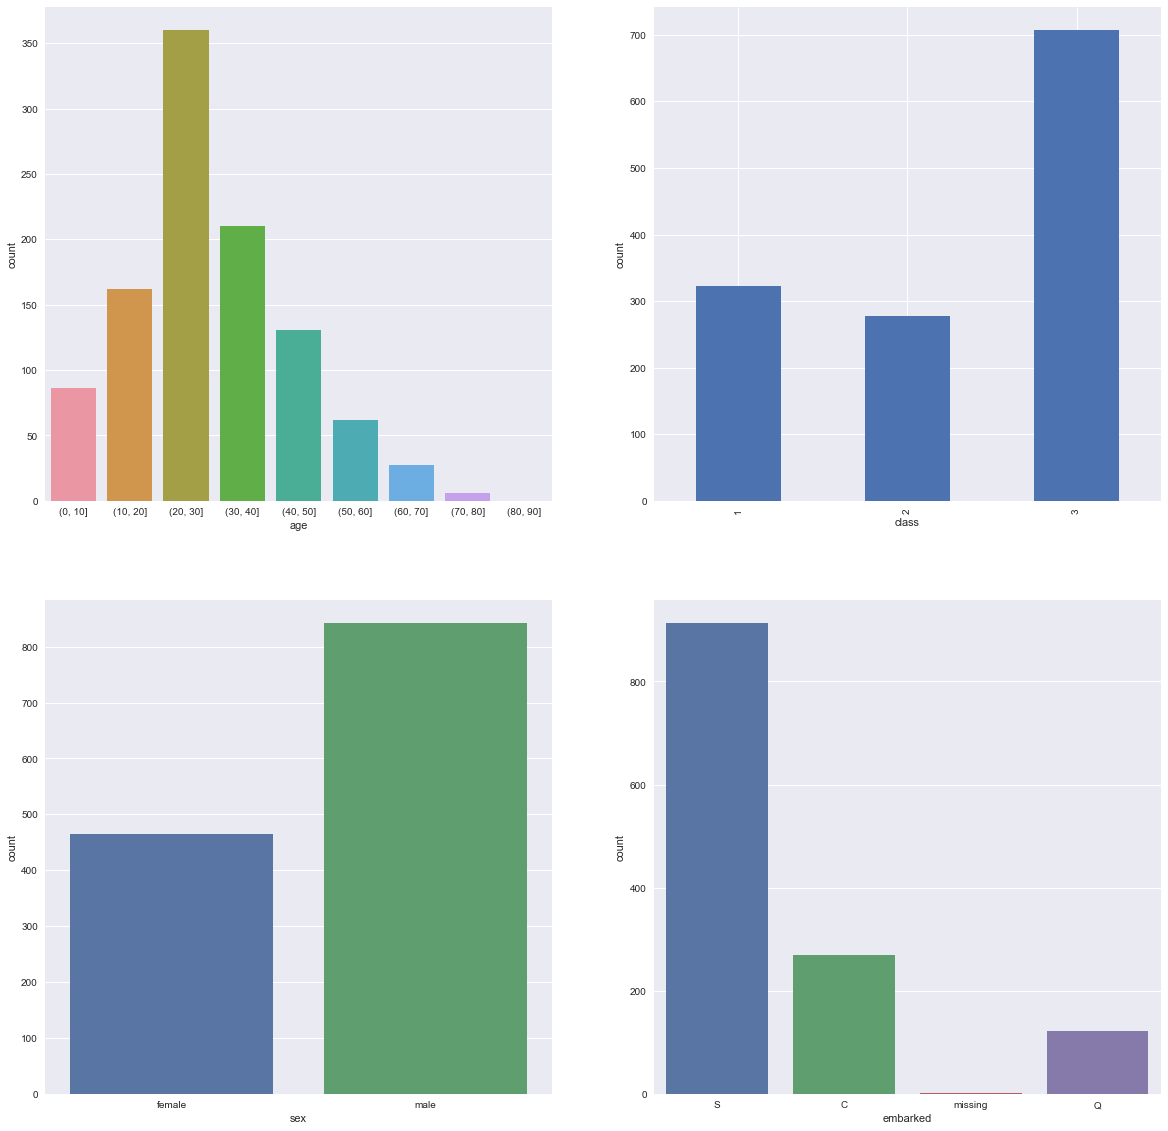

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(20,20)

df_temporary = df3.copy()
df_temporary.age = pd.cut(df3.age, [0,10,20,30,40,50,60,70,80,90])
sns.countplot(x='age',data=df_temporary,ax=axes[0,0])
axes[0,0].set_xlabel('age')
axes[0,0].set_ylabel('count')

classes = df3.groupby('pclass').size()
#df3.hist('pclass',ax=axes[0,1])
classes.plot(kind='bar',ax=axes[0,1])
axes[0,1].set_xlabel('class')
axes[0,1].set_ylabel('count')

sns.countplot(x='sex',data=df3,ax=axes[1,0])

sns.countplot(x='embarked',data=df3)

### Histogram observations
- We can observe the passenger age distribution in the titanic is gaussian
- There is a higher amount of males onboard
- There were more people embarked in third class then first and second combined
- Most of the passengers boarded in Southampton

### 3. Calculate the proportion of passengers by cabin floor
We make the assumption that for cabins with name as 'F E69' belong to the cabin floor F. It should be noted that the following pie chart does not represent perfectly the true proportion of passengers per cabin floor as only 295 out of 1309 values of the cabin column are filled.

In [13]:
df3['cabin_floor'] = df3.cabin.apply(lambda x: x[0])
df3.cabin_floor = df3.cabin_floor[df3.cabin_floor != 'm']

In [17]:
import plotly as ip
import plotly.plotly as py
import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

ip.tools.set_credentials_file(username='mgelsm', api_key='f1kLLDnw63YT86ZkNn3T')
trace = go.Pie(labels=df3['cabin_floor'].value_counts().index, values=df3['cabin_floor'].value_counts())
py.iplot([trace], filename='Proportion of passengers per cabin floor')


from IPython.display import IFrame
IFrame('https://plot.ly/~mgelsm/2', width=800, height=600)

This image is plotted in case the viewer does not run the boxes. The interactive plot is however not available below.
<div>
    <a href="https://plot.ly/~mgelsm/2/?share_key=LTW3TPD50iXkdYukf55G9j" target="_blank" title="Proportion of passengers per cabin floor" style="display: block; text-align: center;"><img src="https://plot.ly/~mgelsm/2.png?share_key=LTW3TPD50iXkdYukf55G9j" alt="Proportion of passengers per cabin floor" style="max-width: 100%;width: 600px;"  width="600" onerror="this.onerror=null;this.src='https://plot.ly/404.png';" /></a>
    <script data-plotly="mgelsm:2" sharekey-plotly="LTW3TPD50iXkdYukf55G9j" src="https://plot.ly/embed.js" async></script>
</div>

### 4. For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

In [15]:
trace = go.Pie(labels=df3.loc[df3.pclass == 1].survived.value_counts().index, values=df3.loc[df3.pclass == 1].survived.value_counts())
py.iplot([trace], filename='Proportion of passengers per cabin floor in first class')

In [18]:
trace = go.Pie(labels=df3.loc[df3.pclass == 2].survived.value_counts().index, values=df3.loc[df3.pclass == 2].survived.value_counts())
py.iplot([trace], filename='Proportion of passengers per cabin floor in second class')

In [19]:
trace = go.Pie(labels=df3.loc[df3.pclass == 3].survived.value_counts().index, values=df3.loc[df3.pclass == 3].survived.value_counts())
py.iplot([trace], filename='Proportion of passengers per cabin floor in third class')

In [20]:

import plotly.plotly as py
from plotly.graph_objs import *

fig = {
    'data': [
        {
              "labelssrc": "mgelsm:37:6e0852",
              "uid": "69a511",
              'name': 'first class',
              "labels": [
                "died",
                "survived"
              ],
              "values": [
                158,
                119
              ],
              "type": "pie",
             'domain': {'x': [0, .3],
                       'y': [0, 1]},
              "valuessrc": "mgelsm:37:346a41",
              'hoverinfo':'label+percent+name',
              'textinfo':'name'
        },
        {
              "labelssrc": "mgelsm:39:868d87",
              "uid": "dd4ae4",
              "name": "Second class",
              "labels": [
                "survived",
                "died"
              ],
              "values": [
                200,
                123
              ],
              "type": "pie",
              'domain': {'x': [.35, 0.65],
                       'y': [0, 1]},
              "valuessrc": "mgelsm:39:e4a7d4",
              'hoverinfo':'label+percent+name'
              
        },
        {
          "labelssrc": "mgelsm:41:d33c0d",
          "uid": "ed234e",
          "labels": [
            "died",
            "survived"
          ],
          "values": [
            526,
            181
          ],
          "type": "pie",
          'domain': {'x': [.7, 1],
                       'y': [0, 1]},
          "valuessrc": "mgelsm:41:ee72c5",
          'hoverinfo':'label+percent+name',
          "name": "3rd class"  
        }
        ],
    'layout': {'title': 'Survival rates per class',
               'showlegend': True}
    }

py.iplot(fig, filename='pie_chart_subplots')
          

Again, the web plot is given here in case the notebook isn't ran by the reader.
<div>
    <a href="https://plot.ly/~mgelsm/42/?share_key=jeDi58oBAX9ggAAVNN5Lfx" target="_blank" title="pie_chart_subplots" style="display: block; text-align: center;"><img src="https://plot.ly/~mgelsm/42.png?share_key=jeDi58oBAX9ggAAVNN5Lfx" alt="pie_chart_subplots" style="max-width: 100%;width: 600px;"  width="600" onerror="this.onerror=null;this.src='https://plot.ly/404.png';" /></a>
    <script data-plotly="mgelsm:42" sharekey-plotly="jeDi58oBAX9ggAAVNN5Lfx" src="https://plot.ly/embed.js" async></script>
</div>


### 5. Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram

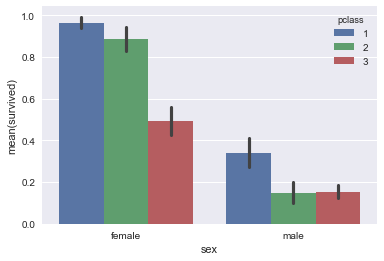

In [137]:
import seaborn as sns
sns.barplot(x='sex',y='survived',hue='pclass',data=df3)

Here we can see that more women survived from the titanic sinking and upper classes have a higher rate of survival.

### 6. Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.

In [138]:
df3['age_class'] = df3.age < df3.age.median()
df3.age.median()

28.0

In [139]:
def create_category(x):
    if x.age_class == False and x.sex == 'female':
        val = 'young_female'
    elif x.age_class == True and x.sex == 'female':
        val = 'old_female'
    elif x.age_class == False and x.sex == 'male':
        val = 'young_male'
    else:
        val = 'old_male'   
    return val

In [140]:
df3['age_sex'] = df3.apply(create_category,axis=1)

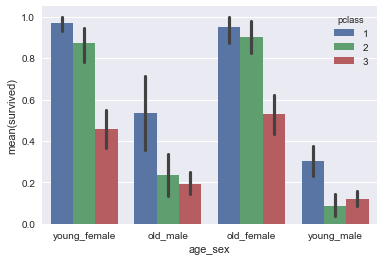

In [141]:
sns.barplot(x='age_sex',y='survived',hue='pclass',data=df3)

This histogram shows two important things :
1. There is a higher rate of Women and children that survived
2. People in hihger classes had better chances of surviving

Hence we can understand that the rule of saving children and women first was applied during the titanic sinking.